## MTurk Data Generation with MS-COCO Dataset

Note that the `.npy` files are pre-processed and saved from previous Coral experiments (`HazyResearch/coral/visual_genome/`). This notebook goes through the objects in each notebook and filters them. It also adds numbers to each bounding box for Turkers to refer to while writing explanations. Finally, it presents a set of images and valid explanations to test the parser. 

The query of interest is: **The highlighted boxes depict a person biking on a street** 

Note each candidate now is a (person,bike) bounding box pair instead of the entire image. This parallels the Spouses task as well. Also, this is different from the Coral experiments since it uses the MS COCO bounding box information, not the captions and annotations from Visual Genome, which were noisy (Coral was accounting for primitive noise as well, so this made sense)


__FOR SOME REASON, THE IMAGES LOADED FROM THE VG DATABASE ARE DIFFERENT FROM THE MSCOCO DATABASE. THEY LOOK THE SAME BUT ARE DIFFERENT SIZES. I THINK. ANYWAY. DONT LOAD VG IMAGES.__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os
import sys
sys.path.append('/dfs/scratch0/paroma/coco')
sys.path.append('/dfs/scratch0/paroma/coco/PythonAPI/')

from pycocotools.coco import COCO
import skimage.io as io
import pylab
import cv2

import pandas as pd

## Load Visual Genome Data
Load the train and validation sets for this task (pre-processed earlier). Split into train and validation based on splits from MS-COCO.

In [7]:
# vg_folder = '/dfs/scratch0/paroma/visual_genome/'
# train_mscoco = np.load(vg_folder+'train_mscoco.npy')
# val_mscoco = np.load(vg_folder+'val_mscoco.npy')

# train_ground = np.load(vg_folder+'train_ground.npy')
# val_ground = np.load(vg_folder+'val_ground.npy')

In [4]:
# #sizes of train-val-test
# print "Train Set Size: ", np.shape(train_mscoco)[0], " Positive: ", np.shape(np.where(train_ground == 1))[1] 
# print "Val Set Size: ", np.shape(val_mscoco)[0], " Positive: ", np.shape(np.where(val_ground == 1))[1] 

## Load MS-COCO Data
Load the annotations for train and validation from MS-COCO database.

In [74]:
def generate_anns(filename, coco_ids=None):
    coco=COCO(filename)
    #catIds = coco.getCatIds(catNms=['person','bicycle']);
    catIds = coco.getCatIds(catNms=['person','wine glass', 'cup', 'bottle']);
    set_anns = []
    valid_coco_ids = []
    
    if coco_ids == None:
        coco_ids = coco.getAnnIds(catIds=catIds, iscrowd=None)

    for set_id in coco_ids:
        annIds = coco.getAnnIds(imgIds=set_id, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        
        if anns == []:
            continue
        categories = [anns[i]['category_id'] for i in range(len(anns))]
        if 1 not in categories:
            continue
        else:
            if (44 not in categories) and (46 not in categories) and (47 not in categories):
                continue

        temp_list = []
        for i in xrange(len(anns)):
            temp_dict = {'category_id':anns[i]['category_id'], 'bbox':anns[i]['bbox']}
            temp_list.append(temp_dict)
        set_anns.append(temp_list)
        valid_coco_ids.append(set_id)
        
    return set_anns, valid_coco_ids

In [75]:
from pycocotools.coco import COCO
coco_path = '/dfs/scratch0/paroma/coco/annotations/'

train_anns, train_mscoco = generate_anns(coco_path+'instances_train2014.json', None)
val_anns, val_mscoco = generate_anns(coco_path+'instances_val2014.json', None)

loading annotations into memory...
Done (t=31.45s)
creating index...
index created!
loading annotations into memory...
Done (t=14.73s)
creating index...
index created!


In [76]:
vg_folder = '/dfs/scratch0/paroma/visual_genome/'
np.save(vg_folder+'drink_train_anns.npy', np.array(train_anns))
np.save(vg_folder+'drink_val_anns.npy', np.array(val_anns))

np.save(vg_folder+'drink_train_mscoco.npy', np.array(train_mscoco))
np.save(vg_folder+'drink_val_mscoco.npy', np.array(val_mscoco))

In [77]:
len(train_anns)

858

In [78]:
len(val_anns)

196

## New Task Instructions
For each image, we now want to:
* Create separate lists of box indices that are person and that are bike
* Create list of tuples of "person,bike"
* Iterate through pairs to check which ones overlap, only save those

Re-calculate the number of candidate pairs and the class balance.

In [79]:
def get_person_bike_boxes(anns):
    person_indices = []
    bike_indices = []
    
    for i in xrange(len(anns)):
        if anns[i]['category_id'] == 1:
            person_indices.append(i)
        if anns[i]['category_id'] == 2:
            bike_indices.append(i)
    
    return person_indices, bike_indices

In [80]:
def get_person_cup_boxes(anns):
    person_indices = []
    bike_indices = []
    
    for i in xrange(len(anns)):
        if anns[i]['category_id'] == 1:
            person_indices.append(i)
        if (anns[i]['category_id'] == 44) or (anns[i]['category_id'] == 46) or (anns[i]['category_id'] == 47):
            bike_indices.append(i)
    
    return person_indices, bike_indices

In [81]:
def overlap(box1, box2):
    if (box1[0]+box1[2]<box2[0] or box2[0]+box2[2]<box1[0] or box1[1]+box1[3]<box2[1] or box2[1]+box2[3]<box1[1]):
        return False
    else:
        return True

In [82]:
def get_valid_pairs(anns, tuples):
    valid_tuples = []
    for person,bike in tuples:
        person_box = anns[person]['bbox']
        bike_box = anns[bike]['bbox']
        
        if overlap(person_box, bike_box):
            valid_tuples.append((person,bike))
    
    return valid_tuples

In [92]:
person_indices, bike_indices = get_person_cup_boxes(train_anns[4])
person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
get_valid_pairs(train_anns[4], person_bike_tuples)

[(0, 1), (0, 2), (0, 3), (4, 1), (4, 3), (5, 1), (6, 1), (6, 2)]

(-0.5, 477.5, 639.5, -0.5)

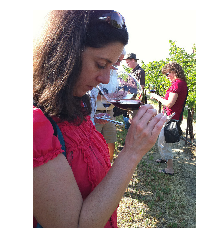

In [90]:
I = io.imread('http://mscoco.org/images/%d'%train_mscoco[4])   
plt.imshow(I); plt.axis('off')

In [93]:
train_anns[4]

[{'bbox': [1.44, 1.08, 397.3, 631.34], 'category_id': 1},
 {'bbox': [186.11, 162.19, 232.32, 191.4], 'category_id': 46},
 {'bbox': [198.02, 250.22, 32.77, 65.98], 'category_id': 46},
 {'bbox': [341.88, 216.89, 18.66, 44.12], 'category_id': 46},
 {'bbox': [339.42, 148.13, 115.05, 335.11], 'category_id': 1},
 {'bbox': [261.82, 124.34, 66.36, 212.22], 'category_id': 1},
 {'bbox': [184.25, 240.07, 62.5, 155.83], 'category_id': 1}]

## Visualization Helper Functions

In [99]:
def annotate_image(coco_id,anns,pidx,bidx):    
    I = io.imread('http://mscoco.org/images/%d'%coco_id)   
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    obj_anns = anns[pidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='cyan',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'X', color='cyan', fontsize=24)

    obj_anns = anns[bidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='yellow',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'Y', color='yellow', fontsize=24)

[(0, 1), (0, 2), (0, 3), (4, 1), (4, 3), (5, 1), (6, 1), (6, 2)]


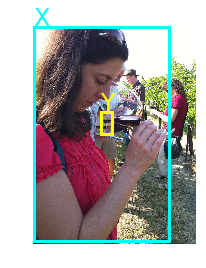

In [102]:
person_indices, bike_indices = get_person_cup_boxes(train_anns[4])
person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
valid_pairs = get_valid_pairs(train_anns[4], person_bike_tuples)
print valid_pairs

plt.figure()
annotate_image(train_mscoco[4],train_anns[4],valid_pairs[1][0], valid_pairs[1][1])

### Save Train Images

In [108]:
def save_annotated_image(train_id,coco_id,anns,pidx,bidx):    
    I = io.imread('http://mscoco.org/images/%d'%coco_id)   
    h,w = np.shape(I)[0:2]
    plt.figure(figsize=(h/36,w/36))
    
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    obj_anns = anns[pidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='cyan',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'X', color='cyan', fontsize=24)

    obj_anns = anns[bidx]
    ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                               obj_anns['bbox'][2],
                               obj_anns['bbox'][3],
                               fill=False,
                               edgecolor='yellow',
                               linewidth=3))
    plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3, 'Y', color='yellow', fontsize=24)
    
    plt.savefig('/dfs/scratch0/paroma/visual_genome/drink_val_%d_%d_%d'%(train_id,pidx,bidx), bbox_inches='tight')
    plt.close()

In [109]:
invalid = []
for i in xrange(len(val_anns)):
    if i%25 == 0:
        print i
    #Find all valid person-bike pairs for given object
    person_indices, bike_indices = get_person_cup_boxes(val_anns[i])
    person_bike_tuples = [(x,y) for x in person_indices for y in bike_indices]
    if person_bike_tuples == []:
        print 'Image ' + str(i) + ' has no person-cup pairs' 
        invalid.append(i)
         
    valid_pairs = get_valid_pairs(val_anns[i], person_bike_tuples)
    if valid_pairs == []:
        print 'Image ' + str(i) + ' has no valid person-cup pairs' 
        invalid.append(i)
    
    for j in xrange(len(valid_pairs)):
        save_annotated_image(i,val_mscoco[i],val_anns[i],valid_pairs[j][0], valid_pairs[j][1])

0
Image 7 has no valid person-cup pairs
Image 8 has no valid person-cup pairs
Image 11 has no valid person-cup pairs
Image 12 has no valid person-cup pairs
Image 16 has no valid person-cup pairs
Image 19 has no valid person-cup pairs
25
Image 26 has no valid person-cup pairs
Image 29 has no valid person-cup pairs
Image 32 has no valid person-cup pairs
Image 38 has no valid person-cup pairs
Image 44 has no valid person-cup pairs
Image 48 has no valid person-cup pairs
Image 49 has no valid person-cup pairs
50
Image 51 has no valid person-cup pairs
Image 58 has no valid person-cup pairs
Image 64 has no valid person-cup pairs
Image 70 has no valid person-cup pairs
Image 74 has no valid person-cup pairs
75
Image 76 has no valid person-cup pairs
Image 79 has no valid person-cup pairs
Image 80 has no valid person-cup pairs
Image 83 has no valid person-cup pairs
Image 84 has no valid person-cup pairs
Image 88 has no valid person-cup pairs
Image 93 has no valid person-cup pairs
100
Image 101 ha

In [110]:
print len(invalid)

54


In [111]:
len(val_anns) - len(invalid)

142